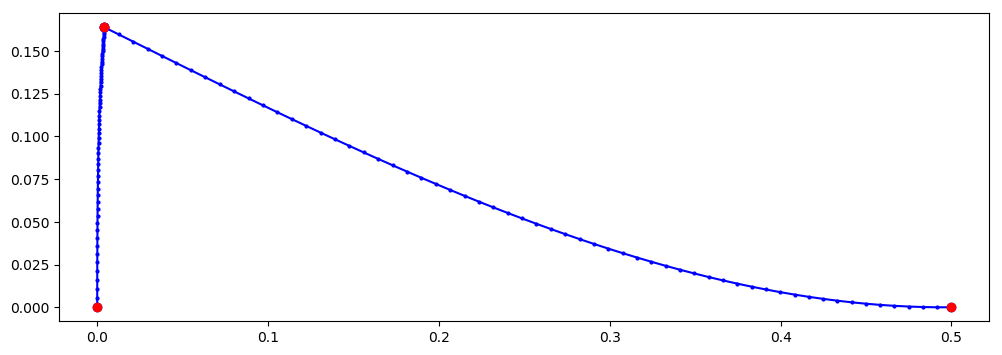

Energy:10.439988610649046

In [49]:
using JuMP, Gurobi
    
    k = 2              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints

    T[1] = 1
    T[2] = 60

function solveOpt(λ)
    xw_a = zeros(2,k)    # vector of waypoint locations
    xw_b = zeros(2,k)    # vector of waypoint locations
    m = Model(solver = GurobiSolver(OutputFlag=0))
    #m = Model(solver = MosekSolver(LOG=0))
    
    @variable(m, x_a[1:2,1:T[k]])  # resulting position
    @variable(m, v_a[1:2,1:T[k]])  # resulting velocity
    @variable(m, u_a[1:2,1:T[k]])  # thruster input
    
    @variable(m, x_b[1:2,1:T[k]])  # resulting position
    @variable(m, v_b[1:2,1:T[k]])  # resulting velocity
    @variable(m, u_b[1:2,1:T[k]])  # thruster input
    
    # define final location they meet each other
    @variable(m, x1 >= 0)
    @variable(m, x2 >= 0)
    @variable(m, y1 >= 0)
    @variable(m, y2 >= 0)
    
    # define waypoints.
    xw_a = [ 0 x1 
             0 y1]

    xw_b = [ 0.5 x2  
             0   y2]

    # satisfy the dynamics (with initial velocity)
    @constraint(m, v_a[:,1] .== [0;20])
    @constraint(m, v_b[:,1] .== [-30;0])

    for t in 1:T[k]-1
        @constraint(m, x_a[:,t+1] .== x_a[:,t] + v_a[:,t]/3600)
        @constraint(m, v_a[:,t+1] .== v_a[:,t] + u_a[:,t])
        @constraint(m, x_b[:,t+1] .== x_b[:,t] + v_b[:,t]/3600)
        @constraint(m, v_b[:,t+1] .== v_b[:,t] + u_b[:,t])
    end

     # hit all the waypoints
     for i in 1:k
         @constraint(m, x_a[:,T[i]] .== xw_a[:,i])
         @constraint(m, x_b[:,T[i]] .== xw_b[:,i])
     end
    
    @constraint(m, x1 == x2) # they should meet at the same place at the end
    @constraint(m, y1 == y2)   
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, sum(u.^2) + λ*sum( (x[:,T]-xw).^2 ) )
    @objective(m, Min, sum(u_a.^2) + sum(u_b.^2))
    solve(m)
    
    Ja = getvalue(sum(u_a.^2))
    xopta = getvalue(x_a)
    
    Jb = getvalue(sum(u_b.^2))
    xoptb = getvalue(x_b)
    return (Ja,xopta,Jb,xoptb,getvalue(xw_a),getvalue(xw_b))
end
;

λ = .01
(Ja,xa,Jb,xb,xw_a,xw_b) = solveOpt(λ)

using PyPlot
figure(figsize=(12,4))
plot( xa[1,:], xa[2,:], "b.-", markersize=4 )
plot( xa[1,T], xa[2,T], "b.", markersize=12 )
plot( xw_a[1,:], xw_a[2,:], "r.", markersize=12 )
plot( xb[1,:], xb[2,:], "b.-", markersize=4 )
plot( xb[1,T], xb[2,T], "b.", markersize=12 )
plot( xw_b[1,:], xw_b[2,:], "r.", markersize=12 )
axis("equal")

print("Energy:",Ja+Jb)

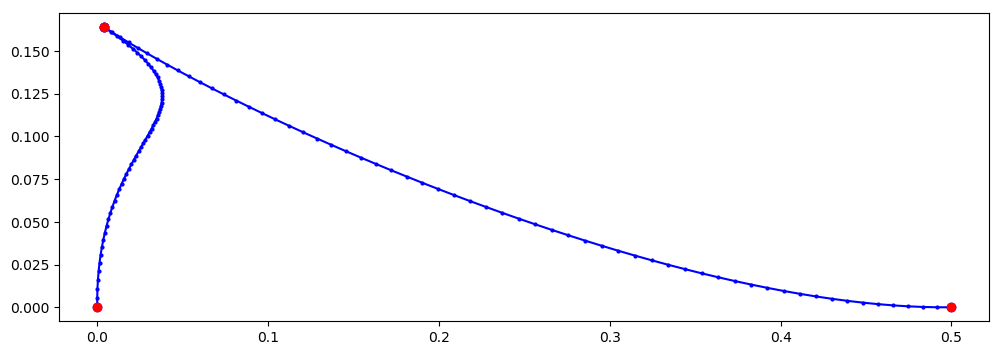

Energy:45.20748100526008

In [50]:
using JuMP, Gurobi

    k = 2              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints

    T[1] = 1
    T[2] = 60

function solveOpt(λ)
    xw_a = zeros(2,k)    # vector of waypoint locations
    xw_b = zeros(2,k)    # vector of waypoint locations
    m = Model(solver = GurobiSolver(OutputFlag=0))
    
    @variable(m, x_a[1:2,1:T[k]])  # resulting position
    @variable(m, v_a[1:2,1:T[k]])  # resulting velocity
    @variable(m, u_a[1:2,1:T[k]])  # thruster input
    
    @variable(m, x_b[1:2,1:T[k]])  # resulting position
    @variable(m, v_b[1:2,1:T[k]])  # resulting velocity
    @variable(m, u_b[1:2,1:T[k]])  # thruster input
    
    # define final location
    @variable(m, x1 >= 0)
    @variable(m, x2 >= 0)
    @variable(m, y1 >= 0)
    @variable(m, y2 >= 0)
    
    # define waypoints.
    xw_a = [ 0 x1 
             0 y1]

    xw_b = [ 0.5 x2  
             0   y2]

    # satisfy the dynamics (with initial velocity)
    @constraint(m, v_a[:,1] .== [0;20])
    @constraint(m, v_b[:,1] .== [-30;0])

    for t in 1:T[k]-1
        @constraint(m, x_a[:,t+1] .== x_a[:,t] + v_a[:,t]/3600)
        @constraint(m, v_a[:,t+1] .== v_a[:,t] + u_a[:,t])
        @constraint(m, x_b[:,t+1] .== x_b[:,t] + v_b[:,t]/3600)
        @constraint(m, v_b[:,t+1] .== v_b[:,t] + u_b[:,t])
    end
    
     # hit all the waypoints
     for i in 1:k
         @constraint(m, x_a[:,T[i]] .== xw_a[:,i])
         @constraint(m, x_b[:,T[i]] .== xw_b[:,i])
     end
    
    @constraint(m, x1 == x2)
    @constraint(m, y1 == y2)
    @constraint(m, v_a[:,60] .== v_b[:,60]) # The final velocity should match
    
    @objective(m, Min, sum(u_a.^2) + sum(u_b.^2))
    solve(m)
    
    Ja = getvalue(sum(u_a.^2))
    xopta = getvalue(x_a)
    
    Jb = getvalue(sum(u_b.^2))
    xoptb = getvalue(x_b)
    return (Ja,xopta,Jb,xoptb,getvalue(xw_a),getvalue(xw_b))
end
;

λ = .01
(Ja,xa,Jb,xb,xw_a,xw_b) = solveOpt(λ)

using PyPlot
figure(figsize=(12,4))
plot( xa[1,:], xa[2,:], "b.-", markersize=4 )
plot( xa[1,T], xa[2,T], "b.", markersize=12 )
plot( xw_a[1,:], xw_a[2,:], "r.", markersize=12 )
plot( xb[1,:], xb[2,:], "b.-", markersize=4 )
plot( xb[1,T], xb[2,T], "b.", markersize=12 )
plot( xw_b[1,:], xw_b[2,:], "r.", markersize=12 )
axis("equal")

print("Energy:",Ja+Jb)